In [1]:
from pandas import read_csv, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split

# File details
filename = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/forecast_gdp_europe.csv"
target = "GDP"
timecol = "Year"

# Load and prepare the data
data = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=[timecol])
series: Series = data[target]

# Split manually (since series_train_test_split expects a DataFrame)
trn_size = int(len(series) * 0.90)
train = series.iloc[:trn_size]
test = series.iloc[trn_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(3, 1, 2)).fit()

# Print model summary
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   52
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -398.984
Date:                Mon, 06 Jan 2025   AIC                            809.968
Time:                        18:11:10   BIC                            821.559
Sample:                    01-01-1960   HQIC                           814.398
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7694      0.100      7.668      0.000       0.573       0.966
ar.L2         -0.9936      0.173     -5.753      0.000      -1.332      -0.655
ar.L3          0.6490      0.153      4.251      0.0

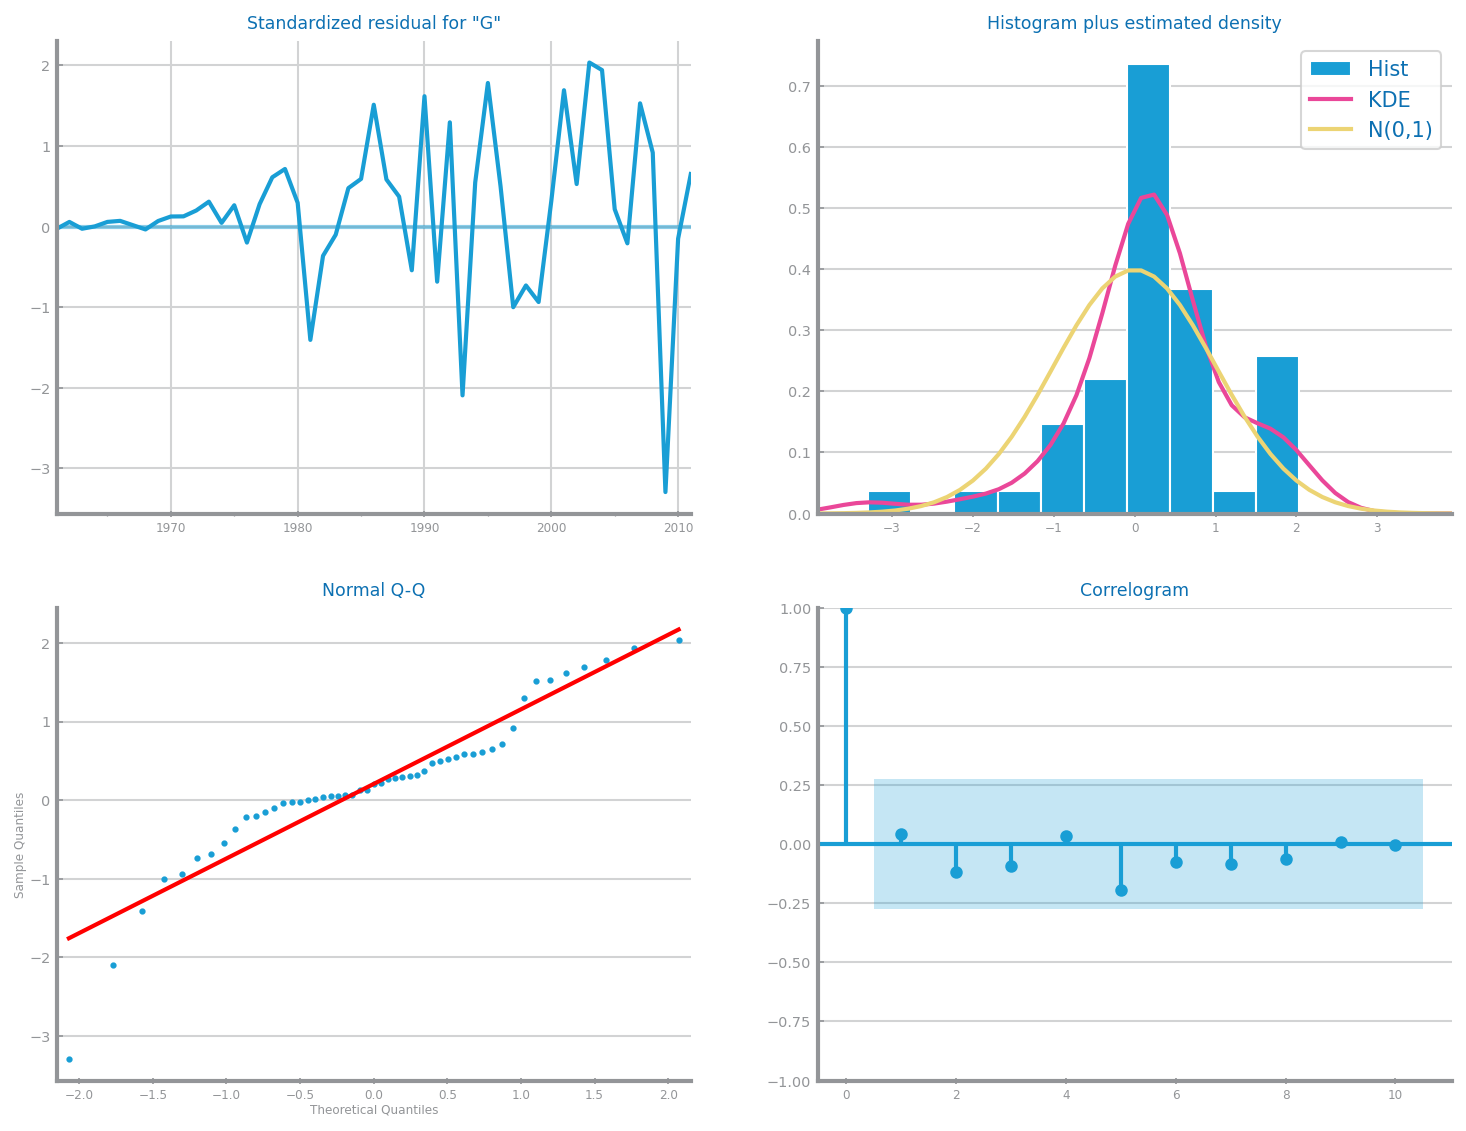

In [4]:
from matplotlib.pyplot import show

# Define a default HEIGHT value (e.g., 6 inches)
HEIGHT = 6

# Plot ARIMA model diagnostics
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))
show()


In [5]:
from pandas import Series
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure, subplots, show
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

def arima_study(train: Series, test: Series, measure: str = "R2"):
    """
    Perform a grid search over ARIMA model parameters to evaluate performance on the test set.

    Parameters:
        train (Series): Training data for ARIMA modeling.
        test (Series): Test data for evaluation.
        measure (str): Evaluation metric (e.g., "R2", "MAPE").

    Returns:
        best_model: Fitted ARIMA model with best performance.
        best_params: Dictionary containing the best ARIMA parameters.
    """
    # Define ARIMA parameter grid
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    # Initialize variables to track the best model
    flag = measure in ["R2", "MAPE"]
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = float("-inf")

    # Create subplots for different d-values
    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * 6, 6))  # Adjust figsize for clarity
    for i, d in enumerate(d_values):
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    # Fit ARIMA model
                    arima = ARIMA(train, order=(p, d, q))
                    model = arima.fit()
                    
                    # Forecast and evaluate
                    prd_tst = model.forecast(steps=len(test))
                    eval_metric = FORECAST_MEASURES[measure](test, prd_tst)

                    # Update best model if performance improves
                    if eval_metric > best_performance and abs(eval_metric - best_performance) > DELTA_IMPROVE:
                        best_performance = eval_metric
                        best_params["params"] = (p, d, q)
                        best_model = model

                    yvalues.append(eval_metric)
                except Exception as e:
                    yvalues.append(float("nan"))  # Handle fitting errors gracefully
            values[q] = yvalues
        
        # Plot performance for the current d-value
        plot_multiline_chart(
            p_params,
            values,
            ax=axs[i],
            title=f"ARIMA d={d} ({measure})",
            xlabel="p",
            ylabel=measure,
            percentage=flag,
        )

    # Print the best ARIMA parameters and performance
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )
    
    return best_model, best_params


In [8]:
from matplotlib.pyplot import savefig

# Define the evaluation measure
measure = "R2"  # Alternativ: "MAPE", "RMSE", etc.

# Run ARIMA study and find the best model
best_model, best_params = arima_study(train, test, measure=measure)

# Save the diagnostic plots
output_path = "/Users/dominikfrank/Library/Mobile Documents/com~apple~CloudDocs/Desktop/University/Master/Semester 1/PII/Data Science/Code for Project/DataScience/images/_arima_{measure}_study.png"
savefig(output_path)
print(f"Plot saved to: {output_path}")


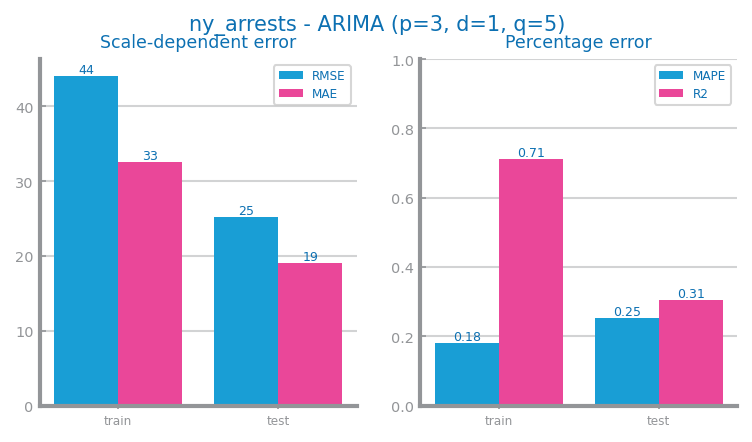

In [7]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_eval.png")

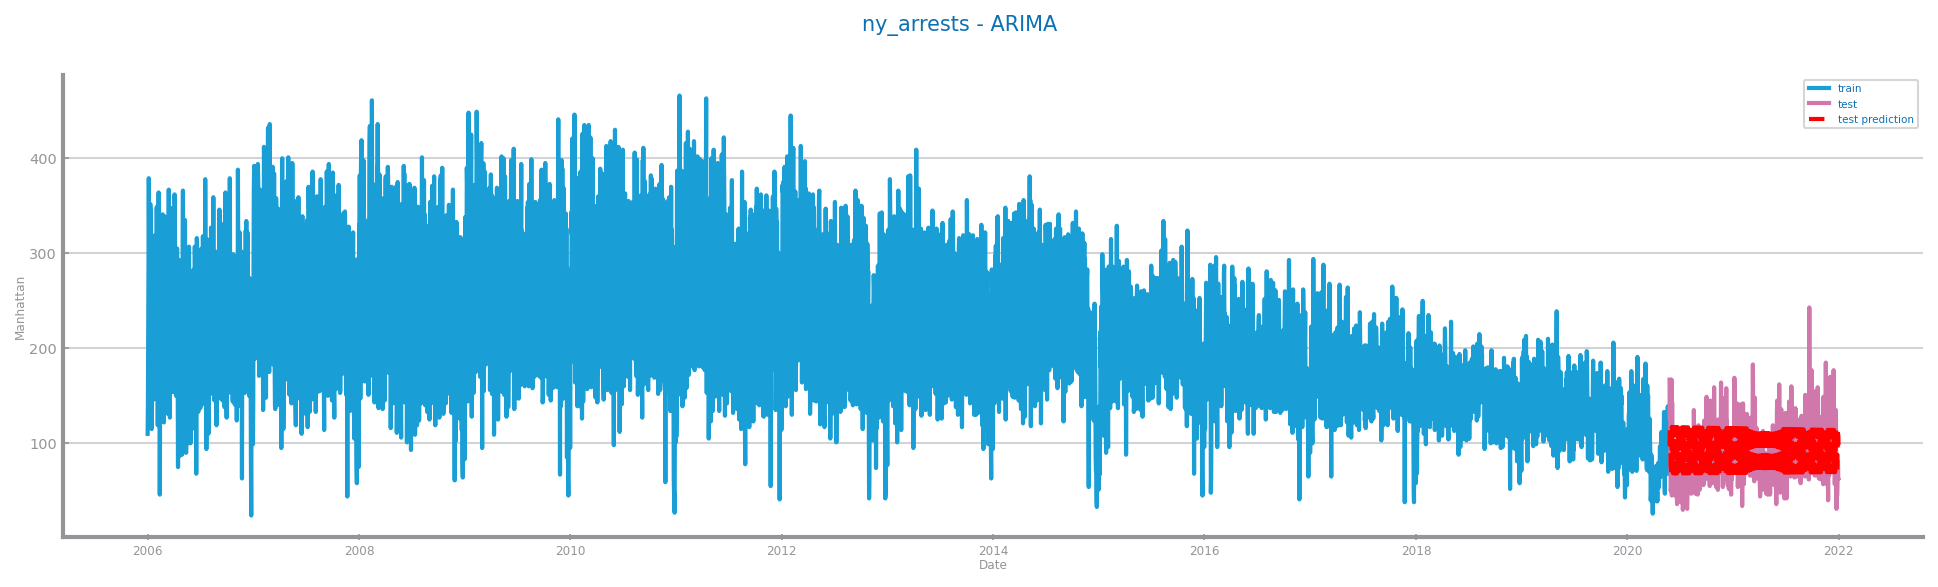

In [8]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_arima_{measure}_forecast.png")
